In [1]:
import pandas as pd
import numpy as np
import torch
import networkx as nx

In [2]:
df = pd.read_csv("data_interpolated.csv")
df.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Hour,Minute,T
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,494.66,0,0,0
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,0,10,1
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76,0,20,2
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53,0,30,3
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36,0,40,4


In [3]:
df = df.sort_values("T").reset_index(drop=True)
split1 = int(df.shape[0]*0.7)
split2 = int(df.shape[0]*0.8)
train = df.iloc[:split1] # 70%
validate = df.iloc[split1:split2] # 10%
test = df.iloc[split2:] # 20%

Setup: We have ground truth data over a graph but some of the values were missing and have been linearly interpolated. That means we can treat those interpolated values as having noise x' = x + n. We can extract the original x by doing regularization.

However because we don't have the ground truth of the missing values, there is no way to validate the performance of the regularizer. 

Option A: Add noise to the true values but not the interpolated ones. Run regularization on all of the points and measure performance based only on the noisy true values. 

Problem: Tikhonov regularizer assumes uniform noise. This means we have to use a custom regularizer and can't use Tikhonov out of the box

Option B: Use mask M to only regularize over interpolated values

Problem: No way to validate regularized values

In [4]:
y = torch.Tensor(train.Patv)

In [5]:
diagonal_vector = torch.Tensor(train.isna().any(axis=1).astype(int))
n = len(diagonal_vector)

# Indices for the sparse matrix (row, column)
indices = torch.stack([
    torch.arange(n),  # row indices
    torch.arange(n)   # column indices (same as row for diagonal)
], dim=0)

In [6]:
M = torch.sparse_coo_tensor(
    indices=indices,
    values=diagonal_vector,
    size=(n, n),
    dtype=torch.float32
)

In [7]:
turbines = pd.read_csv("turbines.csv")
turbines.head()

,TurbID,x,y
0,1,3349.8515,5939.23193
1,2,3351.0017,6416.64673
2,3,3314.7797,6892.18395
3,4,3352.0940,7366.14203
4,5,3355.3420,7841.20175


In [8]:
G = nx.Graph()
turbines.apply(lambda x: G.add_node(int(x.TurbID), pos=(x.x, x.y)), axis=1)
G.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134))

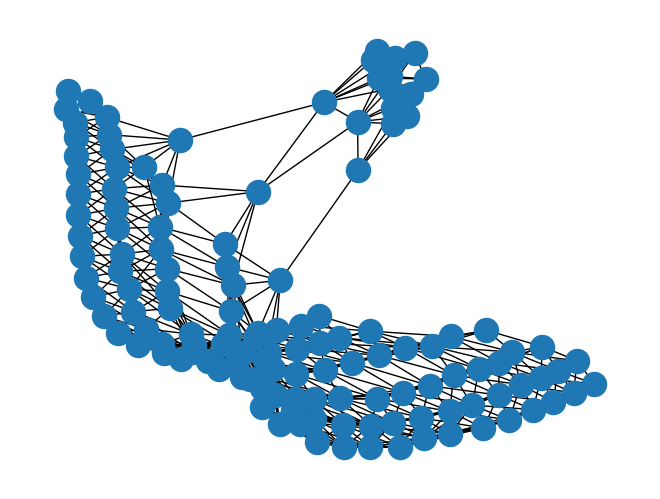

In [9]:
def construct_graph(turbine1, turbine2, max_distance):
    n1 = int(turbine1.TurbID)
    n2 = int(turbine2.TurbID)
    if n1 > n2:
        distance = np.sqrt((turbine2.x - turbine1.x)**2 + (turbine2.y - turbine1.y)**2)
        if distance <= max_distance:
            G.add_edge(n1, n2)
turbines.apply(lambda x: turbines.apply(lambda y: construct_graph(x,y,1500),axis=1),axis=1)
nx.draw(G)